<a href="https://colab.research.google.com/github/SafiyaJan/Attacking-Neural-Networks/blob/master/FGSM_Single.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install foolbox===2.3.0

In [ ]:
import foolbox
import numpy as np
import torch
import torchvision.models as models
from PIL import Image
import torchvision.transforms as transforms
from torch.autograd import Variable
from scipy.special import softmax
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import time 
from skimage.measure import compare_ssim as ssim
from skimage.color import rgb2gray

In [ ]:
# preprocess original image 
def preprocess_orig_image(image):

    im_orig = Image.open(image)
    im = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()])(im_orig)
    im = im.reshape(3,224,224)
    return im

# create foolbox model given the PyTorch model
def test_model(model):
    model = model.eval()
    preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
    fmodel = foolbox.models.PyTorchModel(model, bounds=(0, 1), num_classes=1000, preprocessing=preprocessing)
    return fmodel


def get_labels(label_orig, label_pert):

    labels = open(os.path.join('synset_words.txt'), 'r').read().split('\n')

    str_label_orig = labels[np.int(label_orig)].split(',')[0]
    str_label_pert = labels[np.int(label_pert)].split(',')[0]
    
    return str_label_orig,str_label_pert


# comptute the cosine similarity between 2 original image and adversarial image
def calculate_cossim(orig,pert):

    original_image = orig.flatten()
    perturbed_image = pert.flatten()

    dot_product = np.dot(original_image, perturbed_image)
    norm_a = np.linalg.norm(original_image)
    norm_b = np.linalg.norm(perturbed_image)
    cossimi = ((dot_product / (norm_a * norm_b)))
    return cossimi

def compute_ssim(image1,image2):
  img1_gray = rgb2gray(image1)
  img2_gray = rgb2gray(image2)
  # print (img1_gray.shape)


  score,diff = ssim(img1_gray,img2_gray,full=True)
  # print (score,diff)
  return score
  

def mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

- Load the desired model and convert it to a FoolBox style model
- Preprocess the input image
- Create FGSM attack object
- Run attack on the model, measuring the excution time for it

In [ ]:
# set up model and preprocess image
model = models.inception_v3(pretrained=True) 
fmodel = test_model(model)
image = preprocess_orig_image("test_im1.jpg")
image = image.numpy()

# compute original image confidence
image_label = np.argmax(fmodel.forward_one(image))
orig_confidence = np.amax(foolbox.utils.softmax(fmodel.forward_one(image)))

print ("Starting Attack")
start_time = time.time()
attack = foolbox.v1.attacks.FGSM(fmodel)
adversarial = attack(image, image_label)
end_time = time.time() - start_time
print ("Attack Ended")

# compute adversarial confidence
advs_label = np.argmax(fmodel.forward_one(adversarial))
advs_confidence = np.amax(foolbox.utils.softmax(fmodel.forward_one(adversarial)))

str_label_orig,str_label_advs = get_labels(image_label,advs_label)

# print attack stats
print ("Actual Label:", str_label_orig, "(Confidence: %.2f%%) " % (orig_confidence*100))
print ("Predicted Label:", str_label_advs, "(Confidence: %.2f%%) " % (advs_confidence*100))
print ("Time Taken: %.2f" % end_time)


Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth



Starting Attack
Attack Ended
Actual Label: n01818515 macaw (Confidence: 100.00%) 
Predicted Label: n03724870 mask (Confidence: 38.35%) 
Time Taken: 6.84


Evaluate the MSE value between the Adversarial Example and the Original Image

In [ ]:
orig = np.transpose(image, (1, 2, 0))
pert = np.transpose(adversarial, (1, 2, 0))
print ("MSE Value - ",mse(orig,pert))

MSE Value -  0.1404076651887419


Plot the original image along with the perturbation and the adversarial image

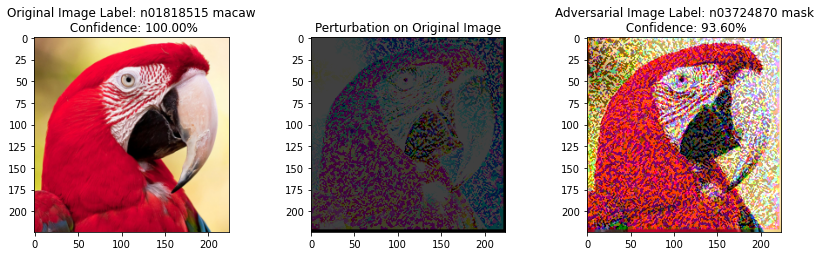

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(1, 3, 1)
plt.imshow(orig)
plt.title("Original Image Label: " + str_label_orig + "\n Confidence: 100.00%")

plt.subplot(1, 3, 2)
plt.imshow(abs(pert-orig),cmap='gray')
plt.title("Perturbation on Original Image")

plt.subplot(1, 3, 3)
plt.imshow(pert)
plt.title("Adversarial Image Label: " + str_label_advs + "\n Confidence: 93.60%")

plt.tight_layout(pad=3.0)
plt.show()

